<a href="https://colab.research.google.com/github/albogdan/aps360-project/blob/master/FeatureKernelOnBerend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchsummary import summary
import os
import time
from google.colab import output

In [ ]:
def progressBar(current, total, barLength = 20):
    output.clear('progress_bar')
    with output.use_tags('status_text'):
      percent = float(current) * 100.0 / total
      arrow   = '-' * int(percent/100 * barLength - 1) + '>'
      spaces  = ' ' * (barLength - len(arrow))
      print("Progress: [{}{}] {} %".format(arrow, spaces, percent))

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
if os.path.exists(os.path.expanduser('~/data')):
  !rm -rf {os.path.expanduser('~/data')}
!unzip '/content/drive/My Drive/APS360 Project/share/BerendImages/mayacaptures.zip' -d {os.path.expanduser('~/data')}

In [ ]:
os.path.exists(os.path.expanduser('~/'))

True

In [ ]:
# Transform Settings - resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                     transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor()])

# define dataloader parameters
num_workers = 4
batch_size = 1

# get dataset
image_set = datasets.ImageFolder(os.path.expanduser('~/data'), transform=data_transform)

# put data inside loader
loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size, 
                                        num_workers=num_workers, shuffle=False)


In [ ]:
print(image_set.class_to_idx)
classes = os.listdir(os.path.expanduser('~/data'))
classes.sort()
classes = classes[:]
print(classes)
print(len(classes))

{'11211': 0, '15571': 1, '22388': 2, '2456': 3, '3001': 4, '3003': 5, '3004': 6, '3007': 7, '3008': 8, '3009': 9, '30136': 10, '3039': 11, '3040': 12, '3044c': 13, '3062b': 14, '35464': 15, '3659': 16, '3660': 17, '3665': 18, '3941': 19, '4070': 20, '42023': 21, '4589b': 22, '4727': 23, '4733': 24, '50950': 25, '54200': 26, '6111': 27, '6232': 28, '6249': 29, '6541': 30, '85984': 31, '87081': 32, '87087': 33, '98100': 34}
['11211', '15571', '22388', '2456', '3001', '3003', '3004', '3007', '3008', '3009', '30136', '3039', '3040', '3044c', '3062b', '35464', '3659', '3660', '3665', '3941', '4070', '42023', '4589b', '4727', '4733', '50950', '54200', '6111', '6232', '6249', '6541', '85984', '87081', '87087', '98100']
35


# Getting features

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
feature_root_path = os.path.expanduser('~/feature')

In [ ]:
for i in classes:
  path = os.path.join(feature_root_path, i)
  if not os.path.exists(path):
    !mkdir -p {path}

In [ ]:
# generate and save feature maps
i = 0
for img, label in loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  features_folder_path = os.path.join(feature_root_path, classes[label])
  feature_path = os.path.join(features_folder_path, "{}.tensor".format(i))
  torch.save(features_tensor.squeeze(0), feature_path)
  i += 1
  print("saved {} images".format(i))

In [ ]:
!zip feature.zip -r {feature_root_path}

# training code

In [ ]:
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def evaluate(model, loader, criterion):
  total_loss = 0.0
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      imgs, labels = data
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      output = model(imgs)

      # select index with maximum prediction score
      pred = output.max(1, keepdim = True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += imgs.shape[0]
      total_loss += criterion(output, labels).item()
  return 1 - correct/total, total_loss

def plot_training_curve(path):
  """ Plots the training curve for a model run, given the csv files
  containing the train/validation error/loss.

  Args:
      path: The base path of the csv files produced during training
  """
  import matplotlib.pyplot as plt
  train_err = np.loadtxt("{}_train_err.csv".format(path))
  val_err = np.loadtxt("{}_val_err.csv".format(path))
  train_loss = np.loadtxt("{}_train_loss.csv".format(path))
  val_loss = np.loadtxt("{}_val_loss.csv".format(path))
  plt.title("Train vs Validation Error")
  n = len(train_err) # number of epochs
  plt.plot(range(1,n+1), train_err, label="Train")
  plt.plot(range(1,n+1), val_err, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Error")
  plt.legend(loc='best')
  plt.show()
  plt.title("Train vs Validation Loss")
  plt.plot(range(1,n+1), train_loss, label="Train")
  plt.plot(range(1,n+1), val_loss, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

In [ ]:
def transfer_train(model, batch_size = 32, num_epochs = 10, lr = 0.003, wd = 1e-5):
  torch.manual_seed(360)

  train_loader, val_loader, test_loader = feature_loader(feature_root_path, 0.6, 0.2, batch_size)

  # Initialize containers for error and loss
  train_err, train_loss, val_err, val_loss = [], [], [], []

  # set up optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = lr, 
                                 weight_decay=wd)

  start_time = time.time()

  for epoch in range(num_epochs):
    epoch_total = 0
    epoch_correct = 0
    epoch_loss = 0
    model.train()
    for feature, labels in iter(train_loader):

      # Enable GPU
      if use_cuda and torch.cuda.is_available():
        feature = feature.cuda()
        labels = labels.cuda()
      
      # zero parameter gradients
      optimizer.zero_grad()

      # forward pass, backward pass, and optimize
      out = model(feature)
      loss = criterion(out, labels)
      loss.backward()
      optimizer.step()
      
      # mini batch statistics
      pred = out.max(1, keepdim = True)[1]
      epoch_correct += pred.eq(labels.view_as(pred)).sum().item()
      epoch_total += feature.shape[0]
      epoch_loss += loss.item()
    train_err.append(1 - (epoch_correct / epoch_total))
    train_loss.append(epoch_loss)
    a, b = evaluate(model, val_loader, criterion)
    val_err.append(a)
    val_loss.append(b)
    
    print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
    print ("train err: {:.4f}, train loss: {:.4f}".format(train_err[epoch], train_loss[epoch]))
    print ("validation err: {:.4f}, validation loss: {:.4f}".format(a, b))

    # save the current model state
    if val_err[-1] < 0.15:
      model_path = get_model_name(model.name, batch_size, lr, epoch)
      torch.save(model.state_dict(), model_path)
  
  print('Finished training in %6.2f s' % (time.time()-start_time))
  np.savetxt("{}_train_err.csv".format(model_path), train_err)
  np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
  np.savetxt("{}_val_err.csv".format(model_path), val_err)
  np.savetxt("{}_val_loss.csv".format(model_path), val_loss)


# training classifier

In [ ]:
# function to load features
def feature_loader(feature_root_path, train_p, val_p, batch_size = 32):
  dataset = torchvision.datasets.DatasetFolder(feature_root_path,\
                                                 loader = torch.load, extensions = ('.tensor'))

  split = [int(train_p * len(dataset)), int(val_p * len(dataset))]
  split.append(len(dataset) - split[1] - split[0])

  train_set, val_set, test_set = torch.utils.data.random_split(dataset, split)
  num_workers = 4

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                             num_workers = num_workers, shuffle = True)
  return train_loader, val_loader, test_loader

In [ ]:
class TransferLearningNetDp3(nn.Module):
  def __init__(self, p=0.0):
    super(TransferLearningNetDp3, self).__init__()
    self.name = "tNetDp3"
    self.fc1 = nn.Linear(256*6*6, 3600)
    self.fc2 = nn.Linear(3600, 1200)
    self.fc3 = nn.Linear(1200, 50)
    self.dropout = nn.Dropout(p=p)
  
  def forward(self, x):
    x = x.view(-1, 256*6*6)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    x = self.dropout(x)
    return x

tNet = TransferLearningNetDp3()
summary(tNet, (256,6,6), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3600]      33,181,200
            Linear-2                 [-1, 1200]       4,321,200
            Linear-3                   [-1, 50]          60,050
           Dropout-4                   [-1, 50]               0
Total params: 37,562,450
Trainable params: 37,562,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.04
Params size (MB): 143.29
Estimated Total Size (MB): 143.36
----------------------------------------------------------------


In [ ]:
#Training with larger batch size
use_cuda = False
tNetDp = TransferLearningNetDp3(0.3)
transfer_train(tNetDp, batch_size=500, num_epochs=100, lr=0.001)

Epoch 0 Finished.  Time per Epoch:  48.20 s 
train err: 0.7268, train loss: 76.1775
validation err: 0.4113, validation loss: 11.5245
Epoch 1 Finished.  Time per Epoch:  48.38 s 
train err: 0.4781, train loss: 44.7274
validation err: 0.2616, validation loss: 6.9607
Epoch 2 Finished.  Time per Epoch:  48.36 s 
train err: 0.4241, train loss: 38.3777
validation err: 0.2403, validation loss: 6.0227
Epoch 3 Finished.  Time per Epoch:  48.64 s 
train err: 0.3891, train loss: 34.5589
validation err: 0.1968, validation loss: 4.8100
Epoch 4 Finished.  Time per Epoch:  48.61 s 
train err: 0.3841, train loss: 33.2669
validation err: 0.1944, validation loss: 4.8045
Epoch 5 Finished.  Time per Epoch:  48.87 s 
train err: 0.3819, train loss: 32.4709
validation err: 0.1708, validation loss: 4.1915
Epoch 6 Finished.  Time per Epoch:  48.88 s 
train err: 0.3610, train loss: 30.6357
validation err: 0.1884, validation loss: 4.7932
Epoch 7 Finished.  Time per Epoch:  49.07 s 
train err: 0.3698, train loss:

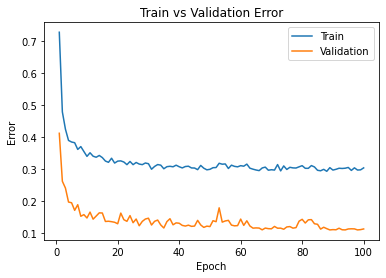

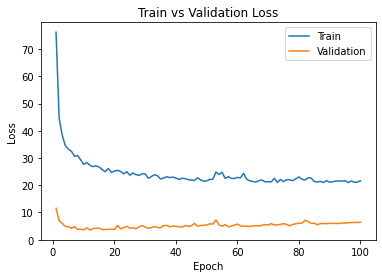

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 500, 0.001, 99))

In [ ]:
# evaluate performance class by class
train_loader, valid_loader, test_loader = feature_loader(feature_root_path, 0.6, 0.2, batch_size = 1)
# load the data first
# the data had been previously copied into the workspace as small set
model = tNetDp
correct = 0
total = 0
correct_by_class = [0 for i in range(0, 27)]
total_per_class = [0 for i in range(0, 27)]
loader = valid_loader
model.eval()
with torch.no_grad():
  for i, data in enumerate(loader, 0):
    feature, labels = data

    output = model(feature)


    # select index with maximum prediction score
    pred = output.max(1, keepdim = True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    correct_by_class[labels] = correct_by_class[labels]\
                                + pred.eq(labels.view_as(pred)).sum().item()
    total += feature.shape[0]
    total_per_class[labels] += 1
print(correct_by_class)
print(total_per_class)
for i in range(0, 27):
  print("Class {}: {} out of {}, {}".format(classes[i], correct_by_class[i], 
                                            total_per_class[i],
                                            correct_by_class[i]/total_per_class[i]))
print(total)

[157, 144, 144, 157, 127, 140, 152, 153, 140, 150, 141, 157, 163, 150, 166, 146, 168, 170, 161, 157, 162, 163, 150, 142, 155, 144, 178]
[164, 158, 146, 165, 141, 152, 159, 156, 154, 150, 144, 161, 173, 152, 176, 153, 169, 171, 161, 162, 175, 164, 153, 165, 155, 163, 178]
Class 11211: 157 out of 164, 0.9573170731707317
Class 15571: 144 out of 158, 0.9113924050632911
Class 22388: 144 out of 146, 0.9863013698630136
Class 2456: 157 out of 165, 0.9515151515151515
Class 3007: 127 out of 141, 0.900709219858156
Class 3008: 140 out of 152, 0.9210526315789473
Class 3009: 152 out of 159, 0.9559748427672956
Class 30136: 153 out of 156, 0.9807692307692307
Class 3044c: 140 out of 154, 0.9090909090909091
Class 3062b: 150 out of 150, 1.0
Class 35464: 141 out of 144, 0.9791666666666666
Class 3660: 157 out of 161, 0.9751552795031055
Class 3665: 163 out of 173, 0.9421965317919075
Class 3941: 150 out of 152, 0.9868421052631579
Class 4070: 166 out of 176, 0.9431818181818182
Class 42023: 146 out of 153, 0.9

IndexError: ignored

In [ ]:
correct = 0
total = 0
correct_by_class = [0 for i in range(0, 27)]
total_per_class = [0 for i in range(0, 27)]
loader = test_loader
model.eval()
with torch.no_grad():
  for i, data in enumerate(loader, 0):
    feature, labels = data

    output = model(feature)


    # select index with maximum prediction score
    pred = output.max(1, keepdim = True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    correct_by_class[labels] = correct_by_class[labels]\
                                + pred.eq(labels.view_as(pred)).sum().item()
    total += feature.shape[0]
    total_per_class[labels] += 1
print(correct_by_class)
print(total_per_class)
for i in range(0, 27):
  print("Class {}: {} out of {}, {}".format(classes[i], correct_by_class[i], 
                                            total_per_class[i],
                                            correct_by_class[i]/total_per_class[i]))
print(total)

[155, 136, 160, 141, 154, 153, 159, 149, 161, 141, 163, 155, 160, 170, 156, 162, 167, 151, 155, 137, 140, 167, 163, 154, 145, 143, 147]
[161, 148, 163, 144, 163, 166, 169, 151, 171, 141, 172, 157, 170, 170, 169, 169, 167, 151, 156, 143, 161, 170, 167, 171, 145, 158, 147]
Class 11211: 155 out of 161, 0.9627329192546584
Class 15571: 136 out of 148, 0.918918918918919
Class 22388: 160 out of 163, 0.9815950920245399
Class 2456: 141 out of 144, 0.9791666666666666
Class 3007: 154 out of 163, 0.9447852760736196
Class 3008: 153 out of 166, 0.9216867469879518
Class 3009: 159 out of 169, 0.9408284023668639
Class 30136: 149 out of 151, 0.9867549668874173
Class 3044c: 161 out of 171, 0.9415204678362573
Class 3062b: 141 out of 141, 1.0
Class 35464: 163 out of 172, 0.9476744186046512
Class 3660: 155 out of 157, 0.9872611464968153
Class 3665: 160 out of 170, 0.9411764705882353
Class 3941: 170 out of 170, 1.0
Class 4070: 156 out of 169, 0.9230769230769231
Class 42023: 162 out of 169, 0.9585798816568047

# complete Berend data set

In [ ]:
class TransferLearningNetDp4(nn.Module):
  def __init__(self, p=0.0):
    super(TransferLearningNetDp4, self).__init__()
    self.name = "tNetDp3"
    self.fc1 = nn.Linear(256*6*6, 3600)
    self.fc2 = nn.Linear(3600, 1200)
    self.fc3 = nn.Linear(1200, len(classes))
    self.dropout = nn.Dropout(p=p)
  
  def forward(self, x):
    x = x.view(-1, 256*6*6)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    x = self.dropout(x)
    return x

tNet = TransferLearningNetDp4()
summary(tNet, (256,6,6), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3600]      33,181,200
            Linear-2                 [-1, 1200]       4,321,200
            Linear-3                   [-1, 35]          42,035
           Dropout-4                   [-1, 35]               0
Total params: 37,544,435
Trainable params: 37,544,435
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.04
Params size (MB): 143.22
Estimated Total Size (MB): 143.29
----------------------------------------------------------------


In [ ]:
!rm -rf {"./model*"}

In [ ]:
#Training with larger batch size
use_cuda = True
tNetDp = TransferLearningNetDp4(0.3).cuda()
transfer_train(tNetDp, batch_size=400, num_epochs=100, lr=0.0015)

Epoch 0 Finished.  Time per Epoch:   5.52 s 
train err: 0.7040, train loss: 126.1740
validation err: 0.3652, validation loss: 15.1993
Epoch 1 Finished.  Time per Epoch:   5.56 s 
train err: 0.4600, train loss: 64.4531
validation err: 0.2520, validation loss: 10.4190
Epoch 2 Finished.  Time per Epoch:   5.57 s 
train err: 0.4075, train loss: 55.5382
validation err: 0.2164, validation loss: 8.8273
Epoch 3 Finished.  Time per Epoch:   5.56 s 
train err: 0.3838, train loss: 51.6116
validation err: 0.1725, validation loss: 6.9200
Epoch 4 Finished.  Time per Epoch:   5.56 s 
train err: 0.3640, train loss: 48.2196
validation err: 0.1713, validation loss: 6.7498
Epoch 5 Finished.  Time per Epoch:   5.55 s 
train err: 0.3533, train loss: 45.9800
validation err: 0.1523, validation loss: 6.0540
Epoch 6 Finished.  Time per Epoch:   5.55 s 
train err: 0.3476, train loss: 44.6248
validation err: 0.1491, validation loss: 5.7087
Epoch 7 Finished.  Time per Epoch:   5.62 s 
train err: 0.3282, train los

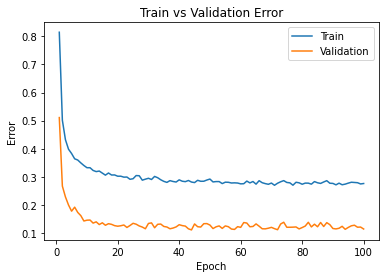

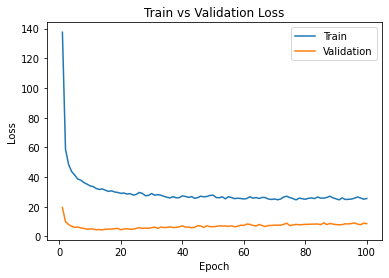

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 500, 0.002, 99))

# Training with Known Negatives

In [ ]:
# load bad ones too
!unzip '/content/drive/My Drive/APS360 Project/heyed.zip' -d {os.path.expanduser('~/data')}

In [ ]:
!rm -rf {os.path.expanduser('~/data/__MACOSX')}

In [ ]:
# Transform Settings - resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                     transforms.Grayscale(num_output_channels=3),
                                      transforms.ToTensor()])

# define dataloader parameters
num_workers = 4
batch_size = 1

# get dataset
image_set = datasets.ImageFolder(os.path.expanduser('~/data'), transform=data_transform)

# put data inside loader
loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size, 
                                        num_workers=num_workers, shuffle=False)


In [ ]:
print(image_set.class_to_idx)
classes = os.listdir(os.path.expanduser('~/data'))
classes.sort()
classes = classes[:]
print(classes)
print(len(classes))
totalCount = 0
for c in classes:
  totalCount += len(os.listdir(os.path.join(os.path.expanduser('~/data'), c)))
print(totalCount)

{'11211': 0, '15571': 1, '22388': 2, '2456': 3, '3001': 4, '3003': 5, '3004': 6, '3007': 7, '3008': 8, '3009': 9, '30136': 10, '3039': 11, '3040': 12, '3044c': 13, '3062b': 14, '35464': 15, '3659': 16, '3660': 17, '3665': 18, '3941': 19, '4070': 20, '42023': 21, '4589b': 22, '4727': 23, '4733': 24, '50950': 25, '54200': 26, '6111': 27, '6232': 28, '6249': 29, '6541': 30, '85984': 31, '87081': 32, '87087': 33, '98100': 34, 'heyed': 35}
['11211', '15571', '22388', '2456', '3001', '3003', '3004', '3007', '3008', '3009', '30136', '3039', '3040', '3044c', '3062b', '35464', '3659', '3660', '3665', '3941', '4070', '42023', '4589b', '4727', '4733', '50950', '54200', '6111', '6232', '6249', '6541', '85984', '87081', '87087', '98100', 'heyed']
36
28742


In [ ]:
!rm -rf {os.path.expanduser('~/feature')}

In [ ]:
feature_root_path = os.path.expanduser('~/feature')
for i in classes:
  path = os.path.join(feature_root_path, i)
  if not os.path.exists(path):
    !mkdir -p {path}

In [ ]:
# generate and save feature maps
i = 0
for img, label in loader:
  features = alexnet.features(img)
  features_tensor = torch.from_numpy(features.detach().numpy())
  features_folder_path = os.path.join(feature_root_path, classes[label])
  feature_path = os.path.join(features_folder_path, "{}.tensor".format(i))
  torch.save(features_tensor.squeeze(0), feature_path)
  i += 1
  # print("saved {} images".format(i))
  progressBar(i, totalCount, 20)

Progress: [------------------> ] 99.99652077099715 %


In [ ]:
!zip feature_neg.zip -r {feature_root_path}

In [ ]:
class TransferLearningNetDp5(nn.Module):
  def __init__(self, p=0.0):
    super(TransferLearningNetDp5, self).__init__()
    self.name = "tNetDp3"
    self.fc1 = nn.Linear(256*6*6, 3600)
    self.fc2 = nn.Linear(3600, 1200)
    self.fc3 = nn.Linear(1200, 36)
    # classes is 36 here
    self.dropout = nn.Dropout(p=p)
  
  def forward(self, x):
    x = x.view(-1, 256*6*6)
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    x = self.dropout(x)
    return x

tNet = TransferLearningNetDp5()
summary(tNet, (256,6,6), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 3600]      33,181,200
            Linear-2                 [-1, 1200]       4,321,200
            Linear-3                   [-1, 36]          43,236
           Dropout-4                   [-1, 36]               0
Total params: 37,545,636
Trainable params: 37,545,636
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.04
Params size (MB): 143.23
Estimated Total Size (MB): 143.30
----------------------------------------------------------------


In [ ]:
!rm -rf {"./model*"}

In [ ]:
#Training with larger batch size
use_cuda = True
tNetDp = TransferLearningNetDp5(0.3).cuda()
transfer_train(tNetDp, batch_size=400, num_epochs=100, lr=0.0015)

Epoch 0 Finished.  Time per Epoch:   5.93 s 
train err: 0.6862, train loss: 119.9826
validation err: 0.3982, validation loss: 16.8650
Epoch 1 Finished.  Time per Epoch:   5.86 s 
train err: 0.4512, train loss: 65.9193
validation err: 0.2738, validation loss: 11.6678
Epoch 2 Finished.  Time per Epoch:   5.86 s 
train err: 0.4101, train loss: 58.2921
validation err: 0.2601, validation loss: 10.3030
Epoch 3 Finished.  Time per Epoch:   5.86 s 
train err: 0.3856, train loss: 53.7766
validation err: 0.2189, validation loss: 9.0048
Epoch 4 Finished.  Time per Epoch:   5.86 s 
train err: 0.3703, train loss: 51.3778
validation err: 0.1529, validation loss: 6.6464
Epoch 5 Finished.  Time per Epoch:   5.87 s 
train err: 0.3472, train loss: 47.6343
validation err: 0.1722, validation loss: 6.9594
Epoch 6 Finished.  Time per Epoch:   5.87 s 
train err: 0.3451, train loss: 46.4569
validation err: 0.1470, validation loss: 6.1640
Epoch 7 Finished.  Time per Epoch:   5.95 s 
train err: 0.3437, train lo

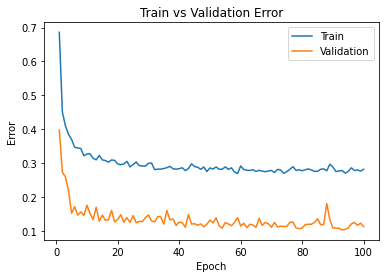

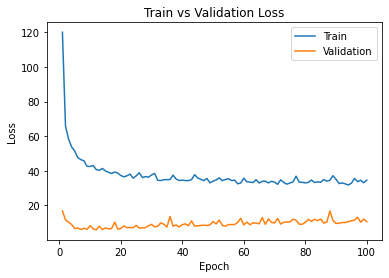

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 400, 0.0015, 99))

In [ ]:
train_loader, valid_loader, test_loader = feature_loader(feature_root_path, 0.6, 0.2, batch_size = 1)
model = TransferLearningNetDp5()
model.load_state_dict(torch.load('./model_tNetDp3_bs400_lr0.0015_epoch92'))

correct = 0
total = 0
correct_by_class = [0 for i in range(0, len(classes))]
total_per_class = [0 for i in range(0, len(classes))]
loader = test_loader
model.eval()
with torch.no_grad():
  for i, data in enumerate(loader, 0):
    feature, labels = data

    output = model(feature)


    # select index with maximum prediction score
    pred = output.max(1, keepdim = True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    correct_by_class[labels] = correct_by_class[labels]\
                                + pred.eq(labels.view_as(pred)).sum().item()
    total += feature.shape[0]
    total_per_class[labels] += 1
print(correct_by_class)
print(total_per_class)
for i in range(0, len(classes)):
  print("Class {}: {} out of {}, {}".format(classes[i], correct_by_class[i], 
                                            total_per_class[i],
                                            correct_by_class[i]/total_per_class[i]))
print(total)

[152, 130, 147, 149, 154, 154, 159, 154, 137, 161, 164, 153, 159, 173, 164, 166, 132, 141, 141, 178, 134, 184, 174, 147, 160, 145, 156, 141, 156, 155, 134, 158, 156, 129, 145, 141]
[159, 146, 153, 156, 154, 156, 170, 167, 162, 169, 166, 161, 168, 184, 164, 178, 135, 152, 147, 179, 147, 187, 174, 148, 160, 152, 159, 164, 164, 160, 146, 164, 156, 155, 146, 141]
Class 11211: 152 out of 159, 0.9559748427672956
Class 15571: 130 out of 146, 0.8904109589041096
Class 22388: 147 out of 153, 0.9607843137254902
Class 2456: 149 out of 156, 0.9551282051282052
Class 3001: 154 out of 154, 1.0
Class 3003: 154 out of 156, 0.9871794871794872
Class 3004: 159 out of 170, 0.9352941176470588
Class 3007: 154 out of 167, 0.9221556886227545
Class 3008: 137 out of 162, 0.845679012345679
Class 3009: 161 out of 169, 0.9526627218934911
Class 30136: 164 out of 166, 0.9879518072289156
Class 3039: 153 out of 161, 0.9503105590062112
Class 3040: 159 out of 168, 0.9464285714285714
Class 3044c: 173 out of 184, 0.94021739

# Qualitative

In [ ]:
model = TransferLearningNetDp5()
model.load_state_dict(torch.load('./model_tNetDp3_bs400_lr0.0015_epoch92'))

<All keys matched successfully>

In [ ]:
dataset = image_set
train_p = 0.6
val_p = 0.2
batch_size = 1

split = [int(train_p * len(dataset)), int(val_p * len(dataset))]
split.append(len(dataset) - split[1] - split[0])

train_set, val_set, test_set = torch.utils.data.random_split(dataset, split)
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            num_workers = num_workers, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size,
                                            num_workers = num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                            num_workers = num_workers, shuffle = True)

In [ ]:
wrongPredictions = [[] for i in classes]
print(wrongPredictions)
for img, label in val_loader:
  # plt.imshow(img.squeeze().permute(1, 2, 0))
  features = alexnet.features(img)
  out = model(features)
  pred = out.max(1, keepdim = True)[1]
  # print(pred)
  correct = pred.eq(label.view_as(pred)).sum().item()
  # print(correct)
  if (correct == 0):
    wrongPredictions[label].append(img)
for i in wrongPredictions:
  print(len(i)) 

In [64]:
def getPred(img):
  features = alexnet.features(img)
  out = model(features)
  pred = out.max(1, keepdim = True)[1]
  return classes[pred]

In [ ]:
for i in range(0, len(wrongPredictions)):
  c = wrongPredictions[i]
  if (len(c) > 0):
    # print("index: {}, class {} wrong".format(i, classes[i]))
    pass
  else:
    print("index: {}, class {} nada".format(i, classes[i]))

index: 4, class 3001 nada
index: 14, class 3062b nada
index: 22, class 4589b nada
index: 23, class 4727 nada
index: 24, class 4733 nada
index: 32, class 87081 nada
index: 35, class heyed nada


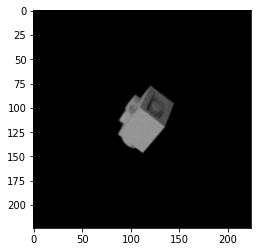

In [ ]:
img = wrongPredictions[0][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

label: 15571
prediction: 3044c


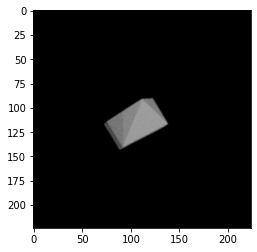

In [71]:
img = wrongPredictions[1][0]
print("label: {}".format(classes[1]))
print("prediction: {}".format(getPred(img)))
out = plt.imshow(img.squeeze().permute(1, 2, 0))

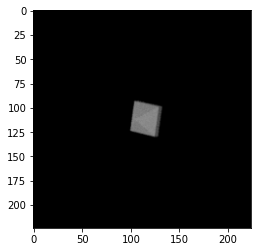

In [ ]:
img = wrongPredictions[2][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

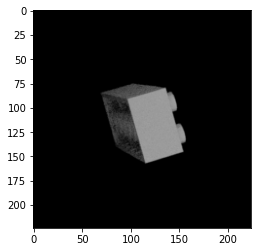

In [ ]:
img = wrongPredictions[3][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

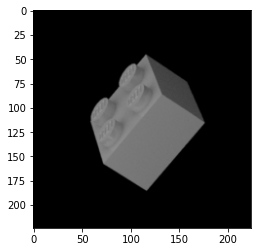

In [ ]:
img = wrongPredictions[5][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

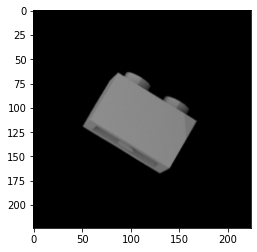

In [ ]:
img = wrongPredictions[6][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

label: 3007
prediction: 6111


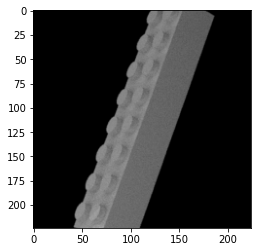

In [72]:
img = wrongPredictions[7][0]
print("label: {}".format(classes[7]))
print("prediction: {}".format(getPred(img)))
out = plt.imshow(img.squeeze().permute(1, 2, 0))

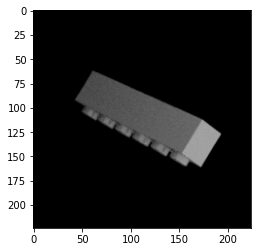

In [ ]:
img = wrongPredictions[9][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

label: 30136
prediction: 11211


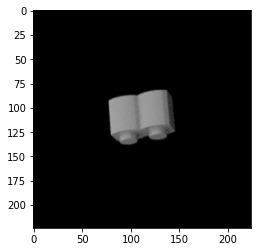

In [82]:
img = wrongPredictions[10][0]
print("label: {}".format(classes[10]))
print("prediction: {}".format(getPred(img)))
plt.imshow(img.squeeze().permute(1, 2, 0))

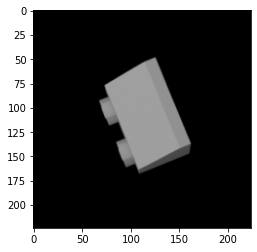

In [ ]:
img = wrongPredictions[11][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

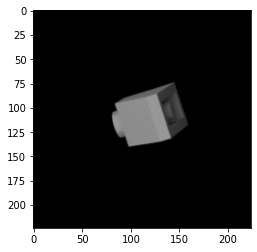

In [ ]:
img = wrongPredictions[12][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

label: 3044c
prediction: 15571


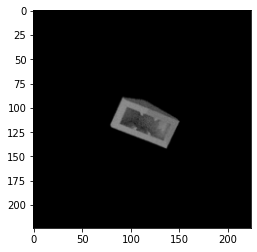

In [77]:
img = wrongPredictions[13][0]
print("label: {}".format(classes[13]))
print("prediction: {}".format(getPred(img)))
output = plt.imshow(img.squeeze().permute(1, 2, 0))

label: 35464
prediction: 22388


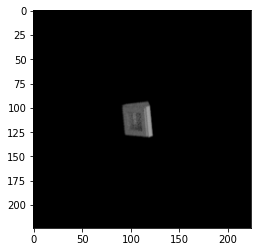

In [78]:
img = wrongPredictions[15][0]
print("label: {}".format(classes[15]))
print("prediction: {}".format(getPred(img)))
output = plt.imshow(img.squeeze().permute(1, 2, 0))

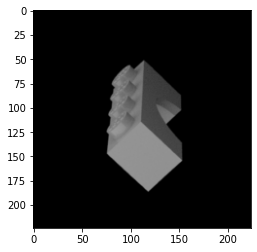

In [ ]:
img = wrongPredictions[16][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

label: 3660
prediction: 11211


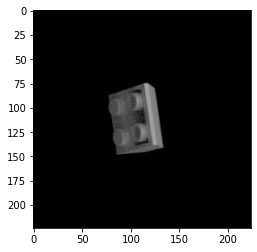

In [83]:
img = wrongPredictions[17][0]
print("label: {}".format(classes[17]))
print("prediction: {}".format(getPred(img)))
plt.imshow(img.squeeze().permute(1, 2, 0))

label: 54200
prediction: 3044c


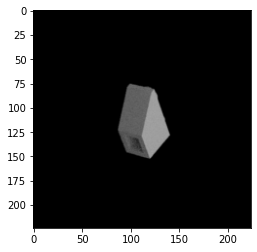

In [79]:
img = wrongPredictions[18][0]
print("label: {}".format(classes[26]))
print("prediction: {}".format(getPred(img)))
plt.imshow(img.squeeze().permute(1, 2, 0))

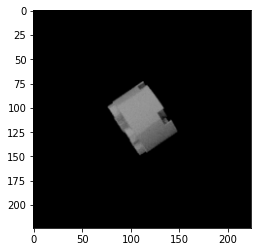

In [ ]:
img = wrongPredictions[19][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

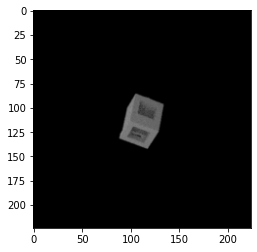

In [ ]:
img = wrongPredictions[20][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

label: 42023
prediction: 50950


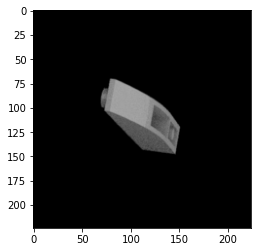

In [81]:
img = wrongPredictions[21][0]
print("label: {}".format(classes[21]))
print("prediction: {}".format(getPred(img)))
plt.imshow(img.squeeze().permute(1, 2, 0))

label: 54200
prediction: 15571


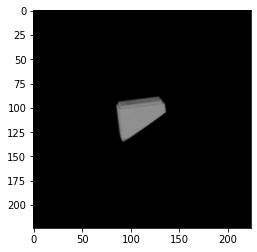

In [66]:
img = wrongPredictions[26][0]
print("label: {}".format(classes[26]))
print("prediction: {}".format(getPred(img)))
out = plt.imshow(img.squeeze().permute(1, 2, 0))

label: 6111
prediction: 3008


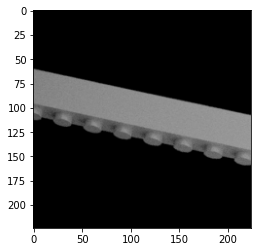

In [76]:
img = wrongPredictions[27][1]
print("label: {}".format(classes[27]))
print("prediction: {}".format(getPred(img)))
out = plt.imshow(img.squeeze().permute(1, 2, 0))

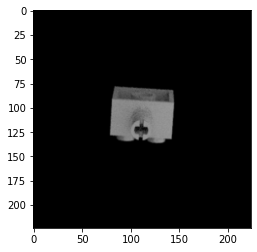

In [ ]:
img = wrongPredictions[28][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

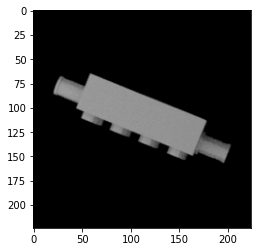

In [ ]:
img = wrongPredictions[29][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

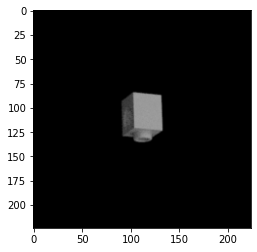

In [ ]:
img = wrongPredictions[30][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

label: 85984
prediction: 15571


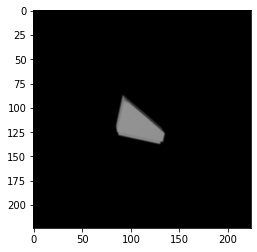

In [73]:
img = wrongPredictions[31][0]
print("label: {}".format(classes[31]))
print("prediction: {}".format(getPred(img)))
out = plt.imshow(img.squeeze().permute(1, 2, 0))

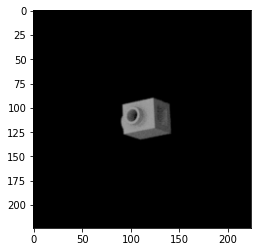

In [ ]:
img = wrongPredictions[33][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

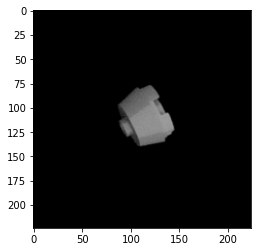

In [ ]:
img = wrongPredictions[34][0]
plt.imshow(img.squeeze().permute(1, 2, 0))

# test on a real image

In [ ]:
model = TransferLearningNetDp5()
model.load_state_dict(torch.load('./model_tNetDp3_bs400_lr0.0015_epoch92'))

<All keys matched successfully>

In [ ]:
# Transform Settings - resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                      transforms.ToTensor()])

# define dataloader parameters
num_workers = 4
batch_size = 1

# get dataset
image_set = datasets.ImageFolder(os.path.expanduser('~/test_images'), transform=data_transform)

# put data inside loader
loader = torch.utils.data.DataLoader(image_set, batch_size=batch_size, 
                                        num_workers=num_workers, shuffle=False)


RuntimeError: ignored

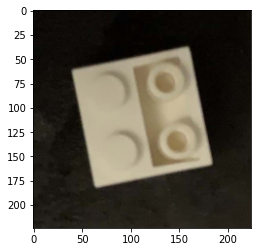

In [ ]:
i = 0
model = tNetDp
for img, label in loader:
  plt.imshow(img.squeeze().permute(1, 2, 0))
  features = alexnet.features(img)
  features = features.cuda()
  out = model(features)
  pred = out.max(1, keepdim = True)[1]
  print(pred)
  break


(649, 652, 3)
(224, 224, 3)


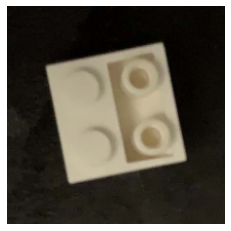

In [ ]:
test_image = io.imread('./IMG_6836_cropped.jpg')
print(test_image.shape)
test_image = transform.resize(test_image, (224, 224))
print(test_image.shape)

plt.imshow(test_image, cmap='gray')
plt.axis('off');

# smaller batch size

In [ ]:
if os.path.exists(os.path.expanduser('~/feature')):
  !rm -rf {os.path.expanduser('~/feature')}
!unzip '/content/drive/My Drive/APS360 Project/share/BerendImages/feature_neg.zip' -d {os.path.expanduser('~/feature')}

In [ ]:
feature_root_path = os.path.expanduser('~/feature/root/feature/')

In [ ]:
#Training with smaller batch size
use_cuda = True
tNetDp = TransferLearningNetDp5(0.1).cuda()
transfer_train(tNetDp, batch_size=40, num_epochs=100, lr=0.0015)

Epoch 0 Finished.  Time per Epoch:  11.30 s 
train err: 0.4303, train loss: 601.8854
validation err: 0.3182, validation loss: 126.8466
Epoch 1 Finished.  Time per Epoch:  11.37 s 
train err: 0.2886, train loss: 364.9653
validation err: 0.2495, validation loss: 94.4615
Epoch 2 Finished.  Time per Epoch:  11.27 s 
train err: 0.2534, train loss: 321.4783
validation err: 0.2347, validation loss: 95.4994
Epoch 3 Finished.  Time per Epoch:  11.25 s 
train err: 0.2253, train loss: 281.4397
validation err: 0.2484, validation loss: 101.1687
Epoch 4 Finished.  Time per Epoch:  11.24 s 
train err: 0.2128, train loss: 266.0054
validation err: 0.1891, validation loss: 81.0962
Epoch 5 Finished.  Time per Epoch:  11.25 s 
train err: 0.2052, train loss: 257.0384
validation err: 0.1940, validation loss: 82.2030
Epoch 6 Finished.  Time per Epoch:  11.26 s 
train err: 0.1886, train loss: 229.5715
validation err: 0.1865, validation loss: 85.7634
Epoch 7 Finished.  Time per Epoch:  11.28 s 
train err: 0.19

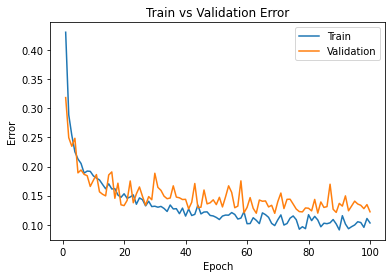

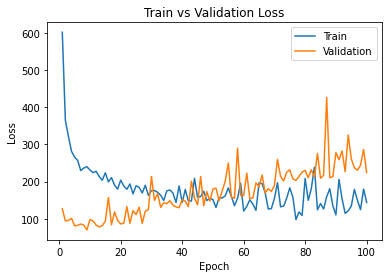

In [ ]:
plot_training_curve(get_model_name(tNetDp.name, 40, 0.0015, 99))